In [1]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, tree
from shap import KernelExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from utils import *

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features),
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_dict, usecols=selected_features)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783531 entries, 0 to 783530
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             783531 non-null  float64
 1   fwd_pkts_tot              783531 non-null  uint64 
 2   bwd_pkts_tot              783531 non-null  uint64 
 3   fwd_data_pkts_tot         783531 non-null  uint64 
 4   bwd_data_pkts_tot         783531 non-null  uint64 
 5   fwd_pkts_per_sec          783531 non-null  float64
 6   bwd_pkts_per_sec          783531 non-null  float64
 7   flow_pkts_per_sec         783531 non-null  float64
 8   down_up_ratio             783531 non-null  float32
 9   fwd_header_size_tot       783531 non-null  uint64 
 10  fwd_header_size_min       783531 non-null  uint8  
 11  fwd_header_size_max       783531 non-null  uint8  
 12  bwd_header_size_tot       783531 non-null  uint64 
 13  bwd_header_size_min       783531 non-null  u

In [4]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000
mean,7.930232,15.141476,15.202140,6.076205,11.985713,2.457452e+03,1960.277241,4.417729e+03,0.828711,5.221322e+02,23.148409,28.325925,4.665602e+02,18.626142,22.381593,0.778524,1.156447,0.418391,5.386756,8.314095,28.377589,0.001020,0.000008,0.001668,0.000037,17.793925,193.943558,1.685628e+03,45.600529,53.879600,22.216197,1167.560257,1.975559e+04,266.243447,343.753524,17.805741,1178.124581,2.144121e+04,159.531792,275.836606,7.863213e+05,4.496497e+06,7.770665e+06,1.097694e+06,9.087544e+05,2.396059e+04,3.669306e+06,5.969705e+06,3.493875e+05,9.122481e+05,7.861756e+05,4.575104e+06,7.941801e+06,9.855074e+05,6.942865e+05,7.737873e+04,10.765978,10.812873,1144.741004,1.200525e+04,23.553719,4.742144e+03,0.034943,1.864668,6.219484e+03,4.144654e+06,6.273139e+05,8.291515e+05,9.390527e+05,7.090896e+05,1.153479e+05,3.233009e+06,4.344537e+06,7.002749e+06,3.663116e+06,5.879498e+05,25885.029520,26880.533083,7417.383553
std,97.220072,390.717612,395.026085,62.401492,393.515497,2.913841e+04,5229.838478,3.047502e+04,0.492997,1.484319e+04,12.629693,15.981276,1.259048e+04,12.781371,16.568396,0.999198,1.029890,0.812277,62.129340,145.891623,785.296047,0.032707,0.002767,0.048602,0.006490,32.828224,300.906381,6.378143e+04,62.585370,91.086309,43.025812,2464.742493,3.385688e+05,509.497456,595.534119,32.883272,2464.226347,3.469619e+05,258.848209,477.557042,6.638000e+06,2.064076e+07,9.716466e+07,6.798270e+06,4.600532e+06,8.692441e+05,1.961555e+07,6.336533e+07,1.924652e+06,4.739904e+06,6.637222e+06,2.069169e+07,9.722218e+07,6.707441e+06,3.368079e+06,3.841924e+06,71.788091,75.387846,14402.013478,1.259423e+05,976.003926,

In [5]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

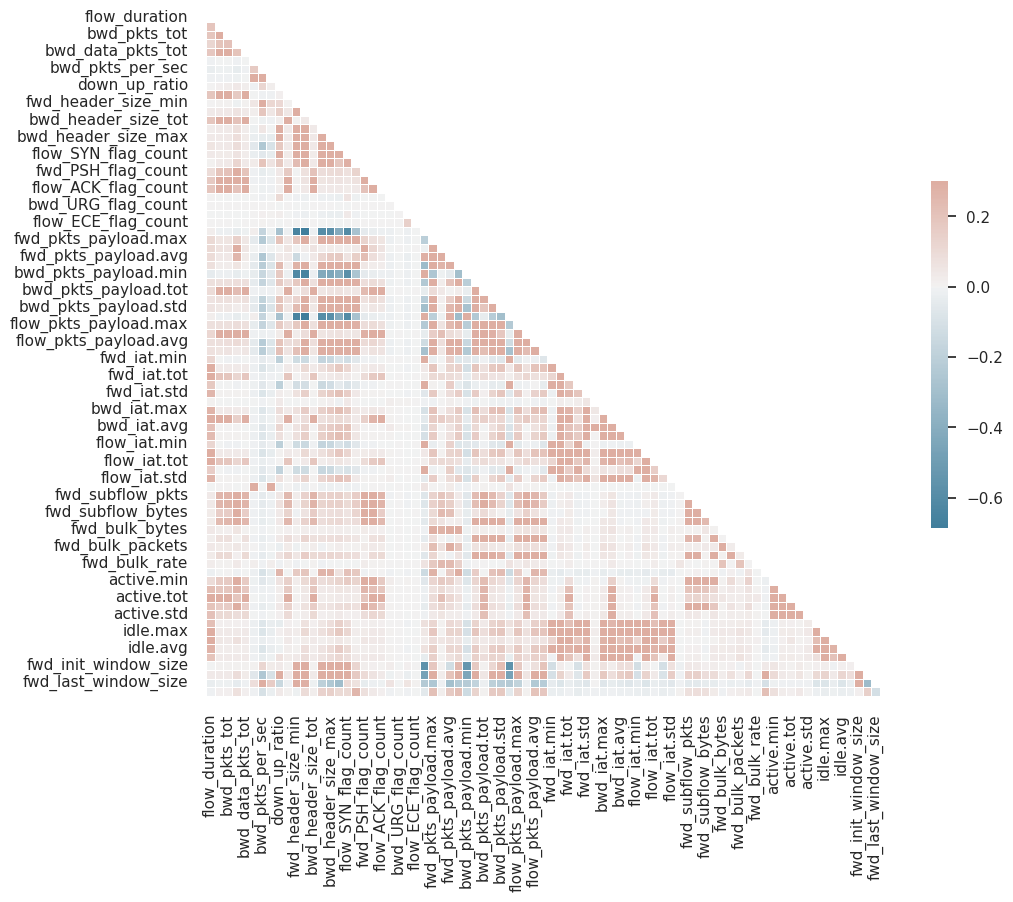

In [6]:
show_corr_matrix(ds)

In [7]:
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [25]:
params = {
    "var_smoothing": 1e-24,
}

In [41]:
nb = GaussianNB(**params)
nb.class_prior_ = [0.05, 0.95]
pv = DataPreprocessingAndValidation(ds, 7988, 5, GaussianNB, params)

In [36]:
X_res, y_res = pv.get_undersampled_ds()
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=y_res)

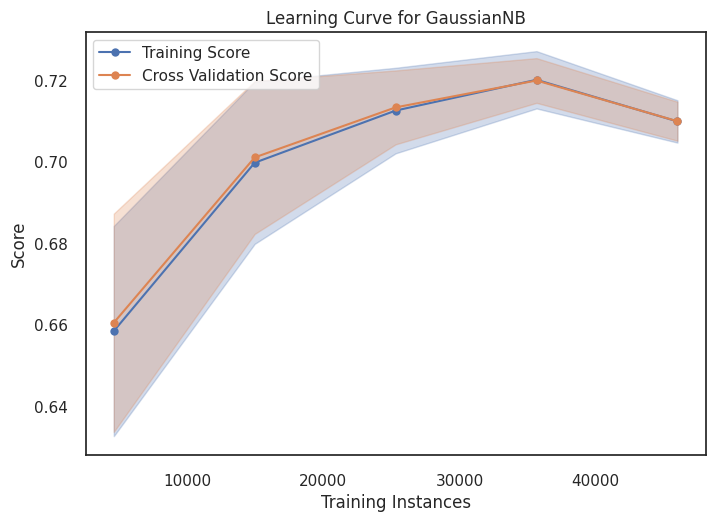

In [13]:
if True:
    cv = 10
    visualizer = LearningCurve(estimator=nb, cv=cv, scoring='f1', n_jobs=-1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="nb_data/learning_curve.png")

![Alt text](nb_data/learning_curve.png)

In [14]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 28.2 s, sys: 194 ms, total: 28.4 s
Wall time: 28.5 s


(0.8404704958273314, 0.0028265426095521163, 0.9689974784851074)

In [42]:
%time nb.fit(X_train, y_train) 

CPU times: user 83.3 ms, sys: 164 µs, total: 83.5 ms
Wall time: 82 ms


GaussianNB(var_smoothing=1e-24)

In [43]:
%time y_predicted_train = nb.predict(X_train)
%time y_predicted_test = nb.predict(X_test)

CPU times: user 69.9 ms, sys: 0 ns, total: 69.9 ms
Wall time: 68.9 ms
CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 17.4 ms


In [44]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.811416,0.809013
1,PRECISION,0.728250,0.725766
2,RECALL,0.993584,0.993428
3,F1 SCORE,0.840473,0.838761
4,AUC,0.811419,0.808999


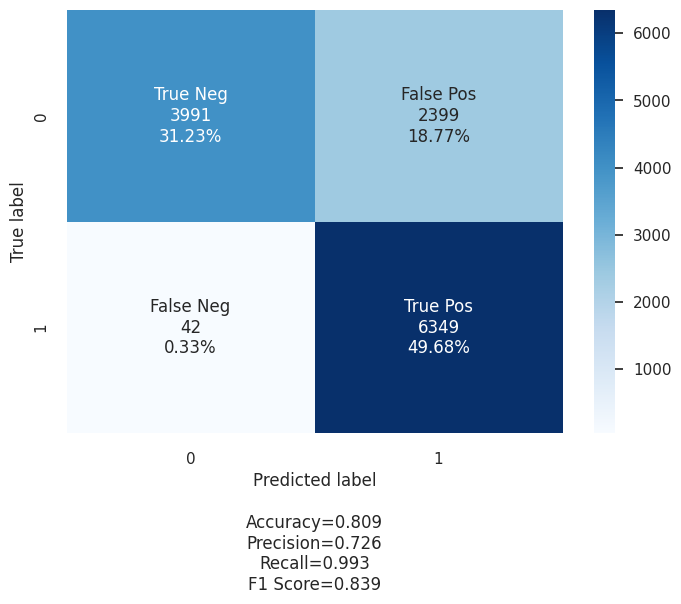

In [45]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [22]:
dot_data = tree.export_graphviz(dt, feature_names=x_features, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render('tree/dt')

'tree/dt.pdf'

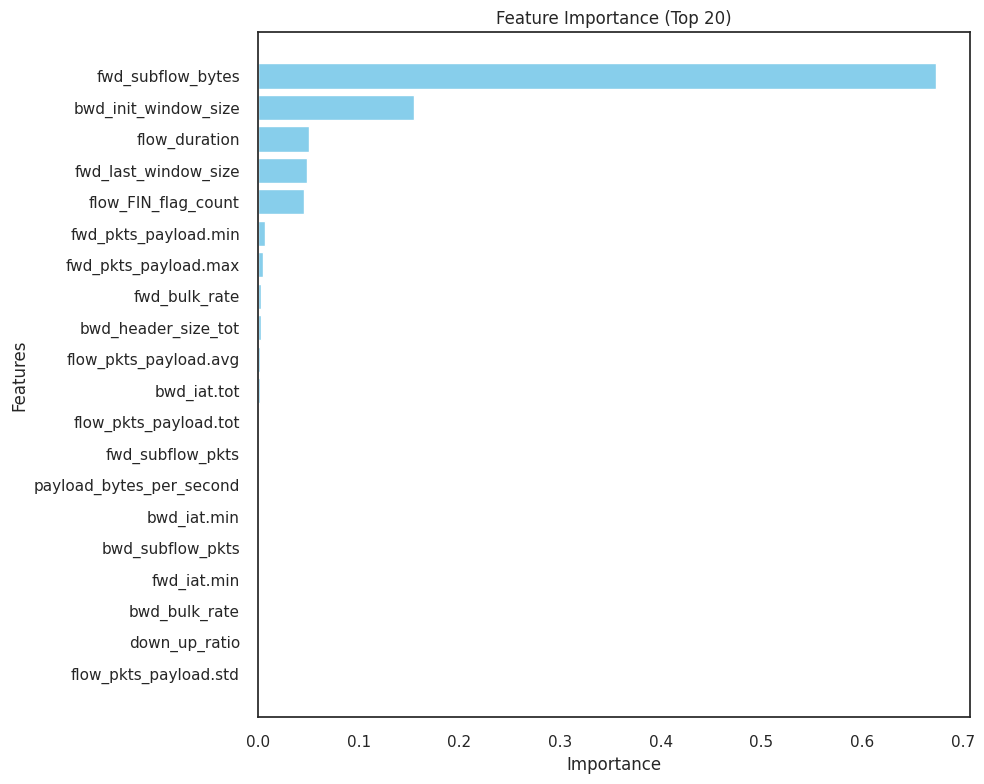

In [23]:
feature_importance = dt.feature_importances_
x_features_np = np.array(x_features)

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = x_features_np[sorted_indices][:20][::-1]  # Select only the first 20 features
sorted_importance = feature_importance[sorted_indices][:20][::-1]  # Select importance values for the first 20 features

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_importance)), sorted_features)  # Use yticks for feature names
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)')
plt.tight_layout()

# Show plot
plt.show()

In [24]:
sampling_weights = {'Background': 10, 'Benign': 10, 'XMRIGCC CryptoMiner': 5, 'Probing': 5, 'Bruteforce': 5, 'Bruteforce-XML': 5}

rus = RandomUnderSampler(random_state=2, sampling_strategy=sampling_weights)
X_shap, y_shap = rus.fit_resample(ds[x_features], ds.traffic_category)

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm import tqdm

scaler = StandardScaler()
scaled_ds = scaler.fit_transform(ds[x_features])

for k in tqdm(range(3, 100)):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_ds)
    explainer = KernelExplainer(dt.predict, kmeans.cluster_centers_)
    sv = explainer.shap_values(X_shap)

    exp = Explanation(
        sv,
        explainer.expected_value,
        data=X_shap,
        feature_names=x_features
    )

    exp.base_values = np.array([exp.base_values])

    # Storing exp using pickle with a filename containing the value of k
    with open(f"100-exp-dt/exp_k_{k}.pkl", "wb") as f:
        pickle.dump(exp, f)

  0%|          | 0/97 [00:00<?, ?it/s]The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  0%|          | 0/40 [00:00<?, ?it/s]divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide

  8%|▊         | 3/40 [00:00<00:04,  8.94it/s]divide by zero encountered in log
invalid value encountered in divide

 22%|██▎       | 9/40 [00:01<00:04,  7.07it/s]divide by zero encountered in log
invalid value encountered in divide

 28%|██▊       | 11/40 [00:01<00:04,  6.91it/s]divide by zero encountered in log
invalid value encountered in divide

 30%|███       | 12/40 [00:01<00:04,  5.97it/s]divide by zero encountered in log
invalid value encountered in divide

 35%|███▌      | 14/40 [00:02<00:05,  4.61it/s]divide 

In [34]:
explainer = fasttreeshap.TreeExplainer(dt, algorithm='auto', n_jobs=-1) 
%time sv = explainer(X_shap)

exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1],
                  data=X_shap, 
                  feature_names=ds[x_features].columns)

CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 21 ms


In [35]:
pd.DataFrame(data = {'importance': exp.mean(0).values}).to_csv('dt_shap.csv')

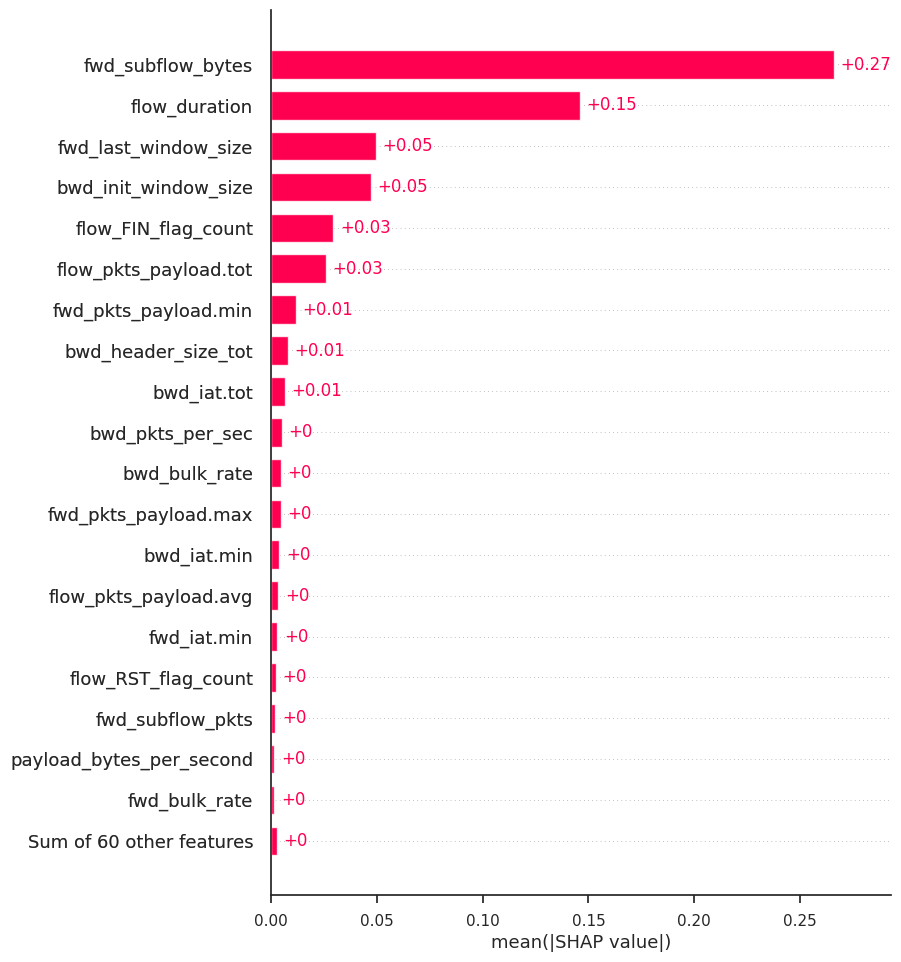

In [105]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

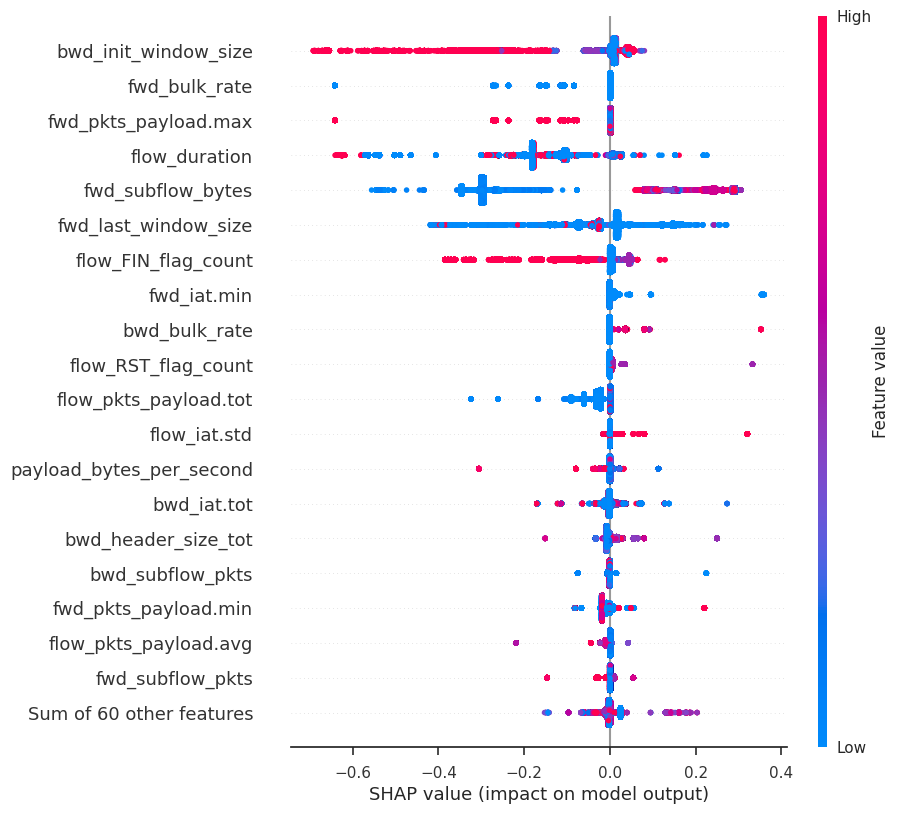

In [106]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [107]:
feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
58,0.265899,fwd_subflow_bytes
0,0.146031,flow_duration
78,0.049343,fwd_last_window_size
77,0.046963,bwd_init_window_size
15,0.029394,flow_FIN_flag_count
37,0.025882,flow_pkts_payload.tot
25,0.011595,fwd_pkts_payload.min
12,0.007849,bwd_header_size_tot
47,0.006420,bwd_iat.tot
6,0.004880,bwd_pkts_per_sec


In [108]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [112]:
def get_score(features):
    start_cv = time.time()
    cv_results = cross_validate(dt, X_res[features], ds.loc[y_res.index].Label, scoring='f1', cv=10, verbose=1, n_jobs=-1)
    end_cv = time.time()
    return cv_results['test_score'].mean(),cv_results['test_score'].std(), len(features), end_cv - start_cv

def recursive_reduction():
    scores = []
    score_std = []
    n_features = []
    cv_time = []
    
    # making a warm up run otherwise the first one will be always slower than the others
    # only one features so that it can be as fast as possibile
    get_score(['fwd_iat.tot'])
    
    result = get_score(feature_above_zero)
    scores.append(result[0])
    score_std.append(result[1])
    n_features.append(result[2])
    cv_time.append(result[3]) 
    
    for i in range(1,len(feature_above_zero)):
        result = get_score(feature_above_zero[:-i])
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])
        cv_time.append(result[3])
        
    return scores, score_std, n_features, cv_time

result = recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

<Axes: xlabel='n_features', ylabel='cv_time'>

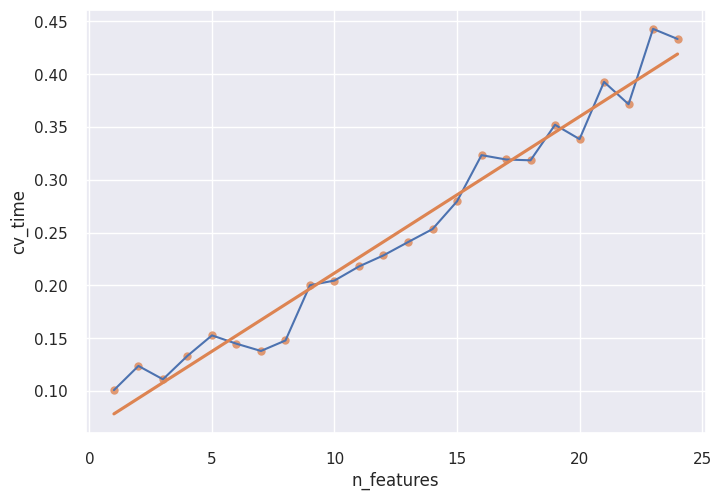

In [113]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

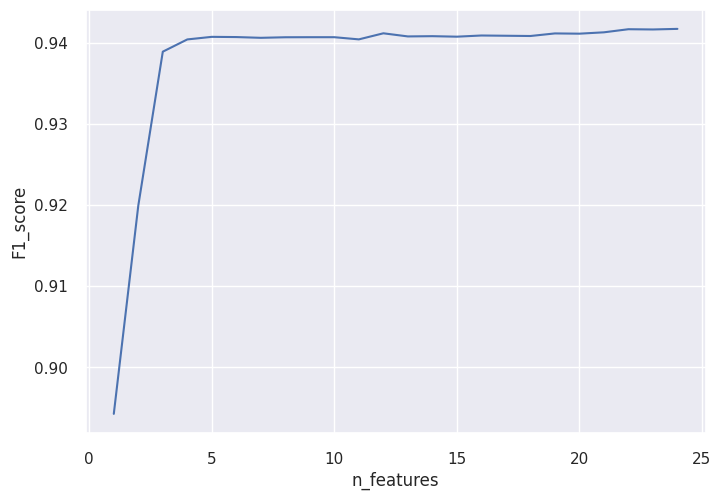

In [114]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

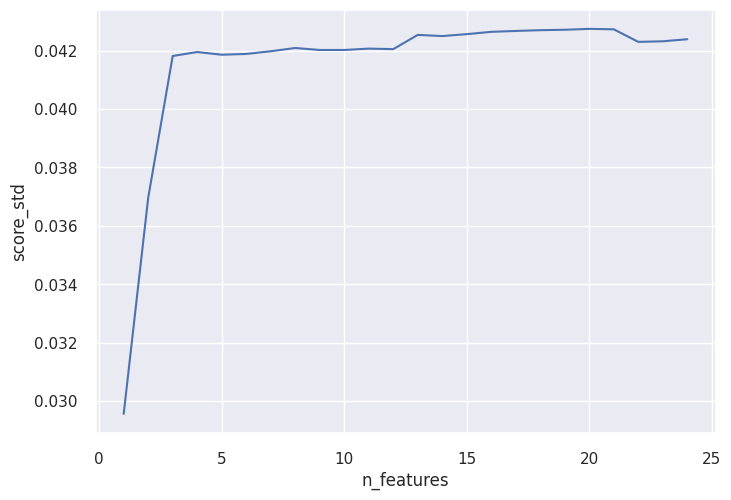

In [115]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [116]:
feature_reduction_scores

,F1_score,score_std,n_features,cv_time
0,0.941690,0.042396,24,0.433391
1,0.941617,0.042325,23,0.442963
2,0.941647,0.042304,22,0.371598
3,0.941266,0.042735,21,0.392735
4,0.941099,0.042750,20,0.338565
5,0.941130,0.042720,19,0.352144
6,0.940811,0.042705,18,0.318499
7,0.940843,0.042679,17,0.319274
8,0.940873,0.042649,16,0.323392
9,0.940729,0.042570,15,0.279645


Here we can have zero on the results of f1 and recall that means that the model has failed to detect the attack, while the cross validation result is usefull only to see how well the model is scoring with all the data except the one regarding the attack

In [117]:
# add also training time
attack_f1 = []
attack_recall = []
attack_precision = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time = []

# warmup boolean, this variable will be used to load in memory the function in order to have reliable time measures
warmup = True

def test_zero_day(attack, features, rus, rus_attack):
    global warmup
    
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    y_res = ds.loc[y_res.index].Label
    
    X_attack, y_attack = rus_attack.fit_resample(ds[features], ds.traffic_category)
    y_attack = ds.loc[y_attack.index].Label
    
    cv_results = cross_validate(dt, X_res, y_res, scoring='f1', cv=10, verbose=0, n_jobs=-1)
    
    if warmup:
        dt.fit(X_res,y_res)
        dt.predict(X_attack)
    
    start_fit = time.time()
    dt.fit(X_res,y_res)
    end_fit = time.time()
    
    start_pred = time.time()
    y_predicted = dt.predict(X_attack)
    end_pred = time.time()
    
    attack_f1.append(metrics.f1_score(y_attack, y_predicted))
    attack_recall.append(metrics.recall_score(y_attack, y_predicted))
    attack_precision.append(metrics.precision_score(y_attack, y_predicted))
    cv_score_avg.append(cv_results['test_score'].mean())
    cv_score_std.append(cv_results['test_score'].std())
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

    # at the very first iteration we change it to false
    warmup = False
    
def recursive_reduction(attack):
    # making a sample for having a 1:1 ration for positive and negative class
    # keep in mind that in the training I will have only three attacks, while for the test only one attack
    sampling_weights = {'Background': 4918, 'Benign': 4918, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
    sampling_attack = {'Background': 1638, 'Benign': 1638, 'XMRIGCC CryptoMiner': 0, 'Probing': 0, 'Bruteforce': 0, 'Bruteforce-XML': 0}
    
    # removing all the attack observations
    sampling_weights[attack] = 0
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    
    # adding the attack to the test dataset with the non attack traffic
    sampling_attack[attack] = 3279
    
    # making the dataset with only one attack
    rus_attack = RandomUnderSampler(random_state=42, sampling_strategy=sampling_attack)
    
    test_zero_day(attack, x_features, rus, rus_attack)
    test_zero_day(attack, feature_above_zero, rus, rus_attack)
    
    for i in range(1,len(feature_above_zero)):
        test_zero_day(attack, feature_above_zero[:-i], rus, rus_attack)
        
for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'attack_precision': attack_precision, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
CPU times: user 1min 25s, sys: 754 ms, total: 1min 26s
Wall time: 1min 31s
traing for  Probing
CPU times: user 1min 21s, sys: 756 ms, total: 1min 22s
Wall time: 1min 27s
traing for  Bruteforce
CPU times: user 1min 18s, sys: 711 ms, total: 1min 19s
Wall time: 1min 22s
traing for  Bruteforce-XML
CPU times: user 1min 18s, sys: 723 ms, total: 1min 19s
Wall time: 1min 23s


In [55]:
# add also training time

attack_f1 = []
attack_recall = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time =  []

def test_zero_day(attack, features):
    # counting how many observation per class we have
    original_weights = ds.groupby('traffic_category', observed=False).count().Label.to_dict()
    # saving a value with the same length of the dataset to be overwritten by the minimun value of a feature class
    minor_class_len = ds.shape[0]
    
    sampling_weights = {'Background': 3279, 'Benign': 3279, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}

    # selecting the minimun between the value in sampling_weights dict and minor_class_len
    sampling_weights[attack] = 0
    for key in list(original_weights.keys()):
        if key != attack:
            minor_class_len = min(minor_class_len, original_weights[key])

    # making a new sampling_weights dict with the attack class removed
    for key in list(sampling_weights.keys()):
        if key != attack:
            sampling_weights[key] = minor_class_len
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    
    # making the split
    X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=42,  stratify=ds.loc[y_res.index].traffic_category)
    
    #rf = RandomForestClassifier(n_jobs=-1, n_estimators=2, max_depth=6, max_features=len(X_train.columns), random_state=42)
    cv_results = cross_validate(dt, X_res, ds.loc[y_res.index].Label, scoring='f1', cv=10, n_jobs=-1)
    start_fit = time.time()
    dt.fit(X_train,y_train)
    end_fit = time.time()
    
    start_pred = time.time()
    y_predicted = dt.predict(ds.where(ds.traffic_category == attack)[features].dropna())
    end_pred = time.time()
    
    attack_f1.append(metrics.f1_score(ds.where(ds.traffic_category == attack)['Label'].dropna().to_list(), y_predicted))
    attack_recall.append(metrics.recall_score(ds.where(ds.traffic_category == attack)['Label'].dropna().to_list(), y_predicted))
    cv_score_avg.append(cv_results['test_score'].mean())
    cv_score_std.append(cv_results['test_score'].std())
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

def recursive_reduction(attack):
    test_zero_day(attack, x_features)
    test_zero_day(attack, feature_above_zero)

    for i in range(1,len(feature_above_zero)):
        test_zero_day(attack, feature_above_zero[:-i])
        
for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
CPU times: user 1min 15s, sys: 3.96 s, total: 1min 19s
Wall time: 1min 29s
traing for  Probing
CPU times: user 1min 16s, sys: 3.98 s, total: 1min 20s
Wall time: 1min 26s
traing for  Bruteforce
CPU times: user 53.1 s, sys: 2.77 s, total: 55.9 s
Wall time: 59.7 s
traing for  Bruteforce-XML
CPU times: user 56.6 s, sys: 2.72 s, total: 59.3 s
Wall time: 1min 3s


In [118]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [119]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
96,0.694528,0.598048,0.828125,0.941050,0.039523,4,Bruteforce-XML,0.018533,0.001267,1
95,0.693957,0.597133,0.828257,0.940857,0.039450,5,Bruteforce-XML,0.018354,0.001137,1
97,0.691450,0.595608,0.824051,0.939366,0.038852,3,Bruteforce-XML,0.017742,0.000974,1
98,0.573278,0.459286,0.762532,0.922266,0.035625,2,Bruteforce-XML,0.018924,0.001227,1
72,0.484723,0.358036,0.750160,0.944593,0.039925,3,Bruteforce,0.019203,0.001450,1
71,0.482002,0.355291,0.749196,0.942928,0.042573,4,Bruteforce,0.018318,0.001255,1
70,0.477155,0.351937,0.740693,0.942853,0.041950,5,Bruteforce,0.019198,0.001411,1
61,0.303522,0.199756,0.631630,0.940758,0.044550,14,Bruteforce,0.046860,0.001352,1
52,0.303381,0.199756,0.630414,0.946111,0.039106,23,Bruteforce,0.082009,0.001760,1
53,0.303522,0.199756,0.631630,0.946120,0.039189,22,Bruteforce,0.080765,0.001636,1


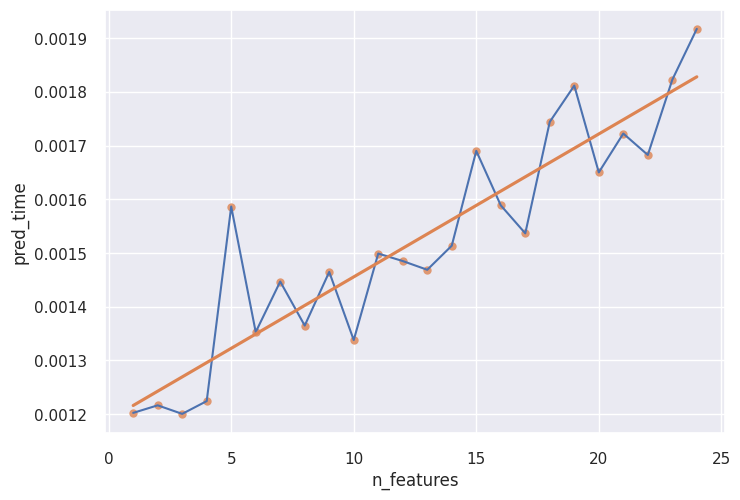

In [120]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

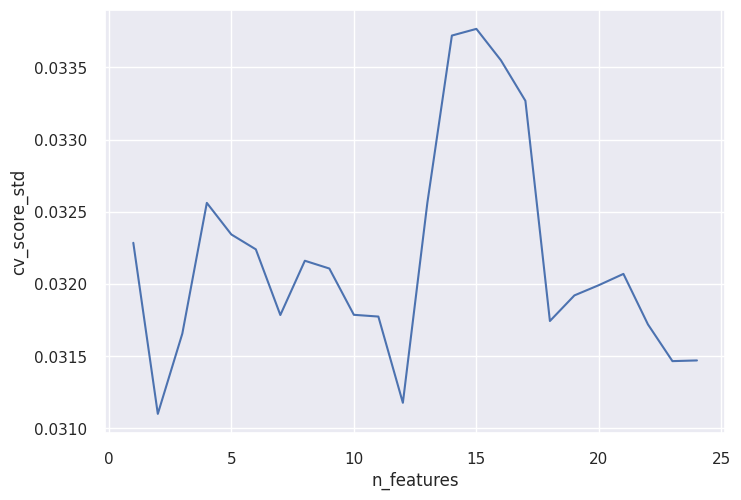

In [121]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [122]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
3,0.294043,0.238411,0.393553,0.951804,0.031656,0.020107,0.001201,0.50
4,0.294133,0.238335,0.394330,0.952679,0.032561,0.021334,0.001224,0.50
5,0.292778,0.237267,0.392238,0.952570,0.032343,0.024280,0.001587,0.50
2,0.145498,0.116041,0.200811,0.938988,0.031101,0.020102,0.001216,0.50
22,0.078857,0.051616,0.171097,0.953628,0.031720,0.100264,0.001683,0.50
23,0.078416,0.051388,0.169022,0.953673,0.031466,0.104105,0.001823,0.50
18,0.076306,0.050168,0.159952,0.953554,0.031744,0.084249,0.001745,0.75
19,0.076306,0.050168,0.159952,0.953578,0.031921,0.090406,0.001812,0.75
21,0.076170,0.050091,0.159297,0.953673,0.032070,0.087652,0.001723,0.50


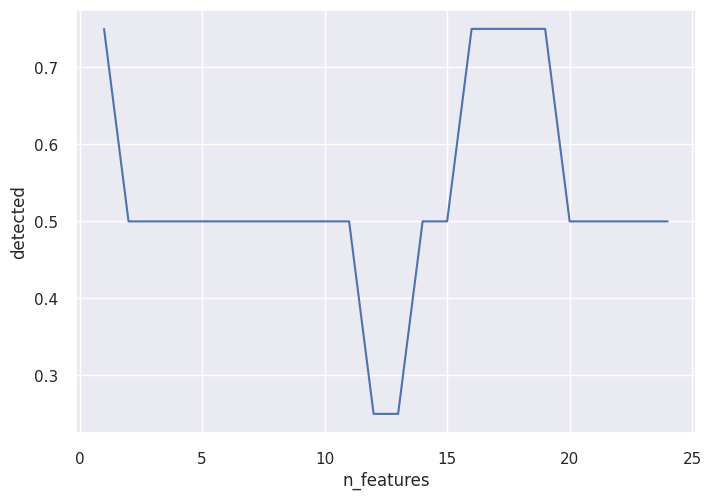

In [123]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

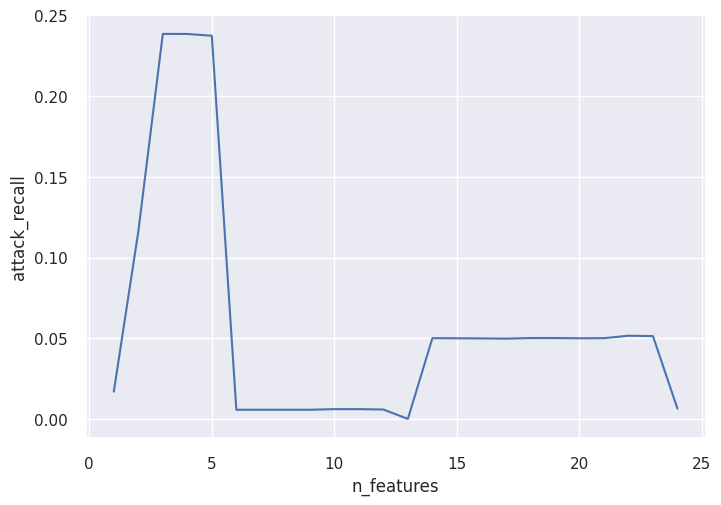

In [124]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [125]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
4,0.294133,0.238335,0.394330,0.952679,0.032561,0.021334,0.001224
3,0.294043,0.238411,0.393553,0.951804,0.031656,0.020107,0.001201
5,0.292778,0.237267,0.392238,0.952570,0.032343,0.024280,0.001587
2,0.145498,0.116041,0.200811,0.938988,0.031101,0.020102,0.001216
22,0.078857,0.051616,0.171097,0.953628,0.031720,0.100264,0.001683
23,0.078416,0.051388,0.169022,0.953673,0.031466,0.104105,0.001823
19,0.076306,0.050168,0.159952,0.953578,0.031921,0.090406,0.001812
18,0.076306,0.050168,0.159952,0.953554,0.031744,0.084249,0.001745
21,0.076170,0.050091,0.159297,0.953673,0.032070,0.087652,0.001723


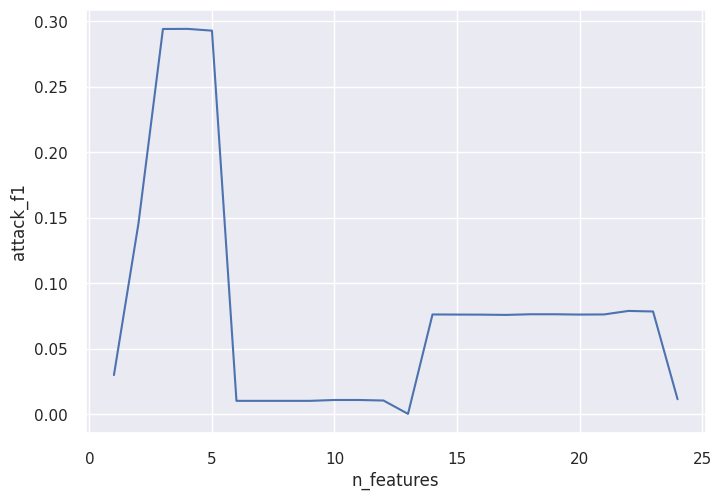

In [126]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [127]:
zero_day_feature_reduction_scores.query('n_features == 3')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
22,0.000000,0.000000,0.000000,0.943387,0.045712,3,XMRIGCC CryptoMiner,0.023074,0.001206,0
47,0.000000,0.000000,0.000000,0.979869,0.002136,3,Probing,0.020408,0.001172,0
72,0.484723,0.358036,0.750160,0.944593,0.039925,3,Bruteforce,0.019203,0.001450,1
97,0.691450,0.595608,0.824051,0.939366,0.038852,3,Bruteforce-XML,0.017742,0.000974,1


In [128]:
zero_day_feature_reduction_scores.query('n_features == 4')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
21,0.000000,0.000000,0.000000,0.946572,0.045826,4,XMRIGCC CryptoMiner,0.028476,0.001290,0
46,0.000000,0.000000,0.000000,0.980166,0.002323,4,Probing,0.020011,0.001086,0
71,0.482002,0.355291,0.749196,0.942928,0.042573,4,Bruteforce,0.018318,0.001255,1
96,0.694528,0.598048,0.828125,0.941050,0.039523,4,Bruteforce-XML,0.018533,0.001267,1
